In [28]:
# using Pkg; Pkg.add("ControlSystemIdentification"); Pkg.add("Optim"); Pkg.add("Plots")

In this notebook, we will explore system identification of an LTI state-space model using [ControlSystemIdentification.jl](https://github.com/baggepinnen/ControlSystemIdentification.jl)
Before any identification can begin, we need to load all the relevant packages. The package Optim does the heavy lifting under the hood, and we load it to be able to s

In [36]:
using ControlSystemIdentification, ControlSystems, Optim, Plots
using Random, LinearAlgebra
using ControlSystemIdentification: newpem
default(size=(500,280))

We start by creating a system to use as the subject of identification

Iter     Function value   Gradient norm 
     0     3.752219e-01     2.846173e+00
 * time: 7.390975952148438e-5


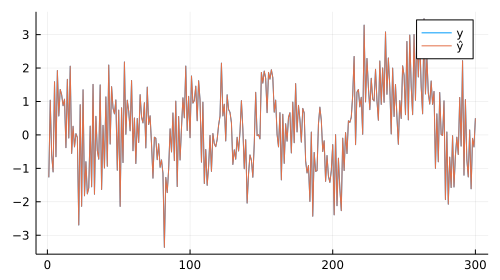

In [37]:
function generate_system(nx,ny,nu)
    A   = randn(nx,nx)
    A   = A - A'
    A  -= 0.1I
    A   = exp(A)
    B   = randn(nx,nu)
    C   = randn(ny,nx)
    sys = ss(A,B,C,0,1)
end

Random.seed!(1)
T   = 300                       # Number of time steps
nx  = 3                         # Number of poles in the true system
nu  = 1                         # Number of control inputs
ny  = 1                         # Number of outputs
x0  = randn(nx)                 # Initial state
sim(sys,u,x0=x0) = lsim(sys, u, 1:T, x0=x0)[1] # Helper function
sys = generate_system(nx,nu,ny)
u   = randn(nu,T)               # Generate random input
y   = sim(sys, u, x0)           # Simulate system
d   = iddata(y,u,1)

sysh,opt = newpem(d, nx) # Estimate model

yh = predict(sysh, d)      # Predict using estimated model
plot([y; yh]', lab=["y" "ŷ"])   # Plot prediction and true output, see also predplot

We could also use the function `predplot` to plot the predicted output together with the measurements.

In the example above, there was no noise on the measurement signal. This is of course not a realistic scenario, and we can increase the realism by simulating some measurement noise

Iter     Function value   Gradient norm 
     0     5.206939e+01     9.417315e+01
 * time: 7.295608520507812e-5
    50     2.823161e+01     6.061666e+02
 * time: 0.042353153228759766


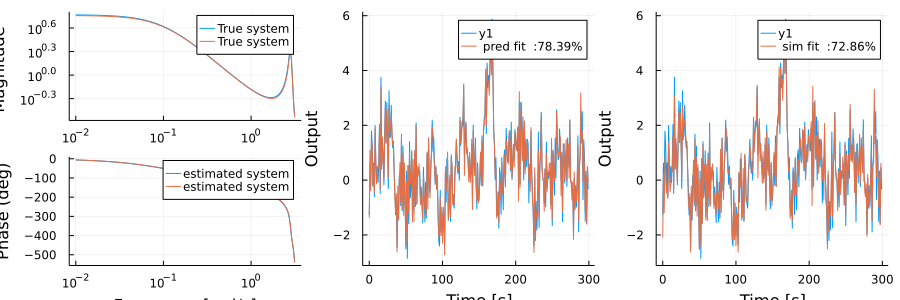

In [38]:
# Both noises
σu = 0.2
σy = 0.2

sysn = generate_system(nx,ny,ny)

u  = randn(nu,T)
un = u + sim(sysn, σu*randn(size(u)),0*x0)
y  = sim(sys, un, x0)
yn = y + sim(sysn, σy*randn(size(u)),0*x0)
dn = iddata(yn, un, 1)
sysh,opt = newpem(dn,nx, iterations=400)
f1 = bodeplot([sys,sysh.sys], lab=["True system" "estimated system"])
f2 = predplot(sysh,dn)
f3 = simplot(sysh,dn)
plot(f1,f2,f3, layout=(1,3), size=(900,300))

We can also optimize other metrics, such as the sum of absolute errors. One can also add a regularization function:

Iter     Function value   Gradient norm 
     0     1.041061e+02     2.935336e+02
 * time: 6.103515625e-5
    50     7.822966e+01     9.149926e+01
 * time: 0.2074291706085205
   100     7.786358e+01     9.284712e+01
 * time: 0.23303818702697754


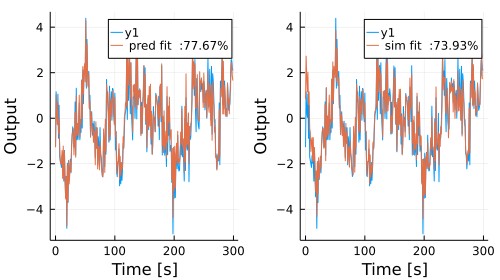

In [42]:
u  = randn(nu,T)
un = u + sim(sysn, σu*randn(size(u)),0*x0)
y  = sim(sys, un, x0)
yn = y + sim(sysn, σy*randn(size(u)),0*x0)
d = iddata(y, u, 1)
dn = iddata(yn, un, 1)
sysh,opt = newpem(dn,nx, metric=abs, regularizer=(p, P)->(0.1/T)*norm(p), iterations=3000)
plot(predplot(sysh,d),simplot(sysh,d))

We now create both test data and validation data and fit 4 different models of increasing order.

In [43]:
σy = 0.5
sim(sys,u) = lsim(sys, u, 1:T)[1]
sys = tf(1,[1,2*0.1,0.1])
sysn = tf(σy,[1,2*0.1,0.3])

# Training data
u  = randn(nu,T)
un = u + 0.1randn(size(u))
y  = sim(sys, u)
yn = y + sim(sysn, σy*randn(size(u)))
dn = iddata(yn, un, 1)

# Validation data
uv  = randn(nu,T)
yv  = sim(sys, uv)
ynv = yv + sim(sysn, σy*randn(size(uv)))
dnv = iddata(ynv, uv, 1)

InputOutput data of length 300 with 1 outputs and 1 inputs

In [44]:
# fit 4 different models
res = [newpem(dn,nx, iterations=50) for nx = 1:4]

Iter     Function value   Gradient norm 
     0     3.252749e+03     9.862239e+03
 * time: 6.890296936035156e-5
    50     2.166017e+02     8.595861e+02
 * time: 0.03091287612915039
Iter     Function value   Gradient norm 
     0     5.947661e+01     5.473508e+02
 * time: 4.410743713378906e-5
    50     5.892303e+00     3.814770e+02
 * time: 0.020408153533935547
Iter     Function value   Gradient norm 
     0     2.451672e+02     2.157385e+04
 * time: 4.100799560546875e-5
    50     1.634334e+01     8.497676e+03
 * time: 0.0279541015625
Iter     Function value   Gradient norm 
     0     1.477232e+01     7.723547e+01
 * time: 4.38690185546875e-5
    50     4.040811e+00     3.030091e+01
 * time: 0.031090974807739258


4-element Vector{Tuple{PredictionStateSpace{Discrete{Float64}, StateSpace{Discrete{Float64}, Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}}, Vector{Float64}, Optim.MultivariateOptimizationResults{BFGS{LineSearches.InitialStatic{Float64}, LineSearches.BackTracking{Float64, Int64}, Nothing, Nothing, Flat}, Vector{Float64}, Float64, Float64, Vector{OptimizationState{Float64, BFGS{LineSearches.InitialStatic{Float64}, LineSearches.BackTracking{Float64, Int64}, Nothing, Nothing, Flat}}}, Bool, NamedTuple{(:f_limit_reached, :g_limit_reached, :h_limit_reached, :time_limit, :callback, :f_increased), NTuple{6, Bool}}}}}:
 (PredictionStateSpace{Discrete{Float64}, StateSpace{Discrete{Float64}, Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}}
A = 
 0.9670657208474821
B = 
 -0.0004164374412114029
C = 
 -2.4167593262889273
D = 
 0.0

Sample Time: 1.0 (seconds)
Discrete-time state-space model, [-0.040944514749169485],  * Status: failure (reac

We can inspect the estimated noise model and compare it to the true noise system

┌ Warning: This call is deprecated due to ambiguity, use covar(ss(D), R) or covar(ss(D, Ts), R) instead
└ @ ControlSystems /home/fredrikb/.julia/dev/ControlSystems/src/ControlSystems.jl:191


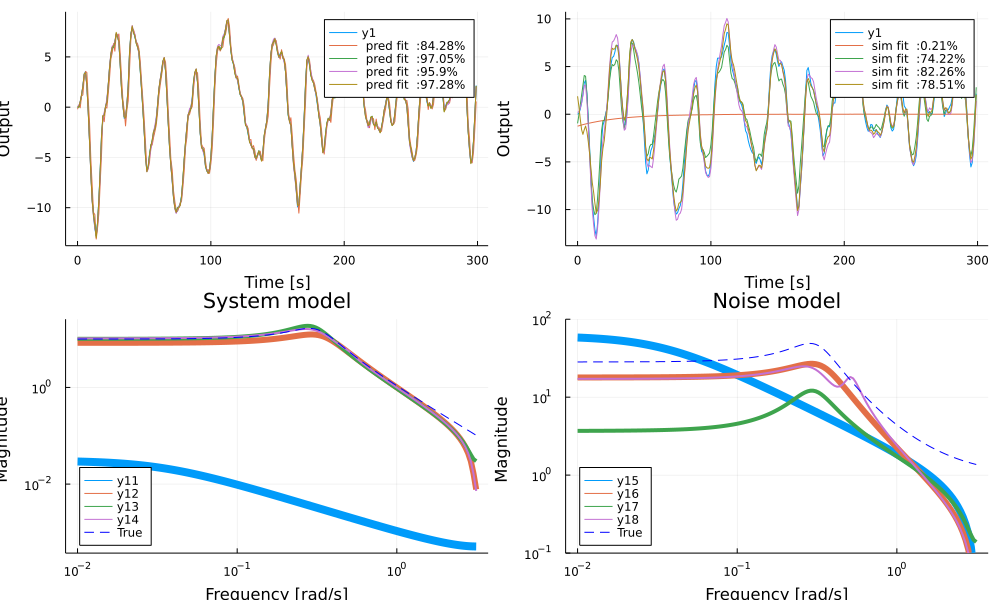

In [46]:
ω = exp10.(range(-2, stop=log10(pi), length=150))
fig = plot(layout=4, size=(1000,600))
for i in eachindex(res)
    (sysh,opt) = res[i]
    predplot!(sysh,dnv; subplot=1, ploty=i==1)
    simplot!(sysh,dnv; subplot=2, ploty=i==1)
end
bodeplot!(getindex.(res,1), ω, plotphase=false, subplot=3, title="Process", linewidth=2*[4 3 2 1])
bodeplot!([noise_model(r[1]) for r in res], ω, plotphase=false, subplot=4, linewidth=2*[4 3 2 1])
bodeplot!(sys, ω, plotphase=false, subplot=3, lab="True", linecolor=:blue, l=:dash, legend = :bottomleft, title="System model")
bodeplot!(ControlSystems.innovation_form(ss(sys),syse=σy^2*ss(sysn), R2=I), ω, plotphase=false, subplot=4, lab="True", linecolor=:blue, l=:dash, ylims=(0.1, 100), legend = :bottomleft, title="Noise model")

We see that adding more than two poles to the model does little to improve the prediction and simulation performance, it is thus a good idea to stick with a second or third-order model.